### Milestone 2

- Decide on our cities
- Git hub for data processing code
- Data processing and answer RQ1
- Update the proposal sheet



First download the data files for local runtime:

In [ ]:
# # # # Download the tourism data and the city listing data:
# !wget https://raw.githubusercontent.com/Rowan441/airbnbtourismdata/master/EuropeTransposed.csv

# !wget https://raw.githubusercontent.com/Rowan441/airbnbtourismdata/master/amsterdam_listings.csv
# !wget https://raw.githubusercontent.com/Rowan441/airbnbtourismdata/master/athens_listings.csv
# !wget https://raw.githubusercontent.com/Rowan441/airbnbtourismdata/master/berlin_listings.csv
# !wget https://raw.githubusercontent.com/Rowan441/airbnbtourismdata/master/brussels_listings.csv
# !wget https://raw.githubusercontent.com/Rowan441/airbnbtourismdata/master/copenhagen_listings.csv
# !wget https://raw.githubusercontent.com/Rowan441/airbnbtourismdata/master/lisbon_listings.csv 

You'll also have to download the cities **calendar** data (at http://insideairbnb.com/get-the-data)

In [ ]:
# !wget http://data.insideairbnb.com/the-netherlands/north-holland/amsterdam/2023-03-09/data/calendar.csv.gz
# !gunzip -c /content/calendar.csv.gz > amsterdam_calendar.csv
# !rm /content/calendar.csv.gz

# !wget http://data.insideairbnb.com/germany/be/berlin/2022-12-21/data/calendar.csv.gz
# !gunzip -c /content/calendar.csv.gz > berlin_calendar.csv
# !rm /content/calendar.csv.gz

# !wget http://data.insideairbnb.com/greece/attica/athens/2022-12-27/data/calendar.csv.gz
# !gunzip -c /content/calendar.csv.gz > athens_calendar.csv
# !rm /content/calendar.csv.gz

# !wget http://data.insideairbnb.com/belgium/bru/brussels/2023-03-24/data/calendar.csv.gz
# !gunzip -c /content/calendar.csv.gz > brussels_calendar.csv
# !rm /content/calendar.csv.gz

# !wget http://data.insideairbnb.com/denmark/hovedstaden/copenhagen/2023-03-31/data/calendar.csv.gz
# !gunzip -c /content/calendar.csv.gz > copenhagen_calendar.csv
# !rm /content/calendar.csv.gz

# !wget http://data.insideairbnb.com/portugal/lisbon/lisbon/2023-03-19/data/calendar.csv.gz
# !gunzip -c /content/calendar.csv.gz > lisbon_calendar.csv
# !rm /content/calendar.csv.gz



In [ ]:
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
import plotly.graph_objects as go
from sklearn.preprocessing import MinMaxScaler

In [ ]:
#graphing colours and options
G8_Pink = '#c353db'
G8_Purple = '#805cd5'
G8_Blue = '#657ecf'
G8_LightBlue = '#6eb4c9'
G8_Green = '#76c4ad'
G8_BrightGreen = '#76EF70'

color_list = [G8_Pink, G8_LightBlue, G8_Green, G8_Purple, G8_Blue, G8_BrightGreen]

sns.set(
        rc={
 'axes.axisbelow': False,
 'axes.edgecolor': 'dimgrey',
 'axes.facecolor': 'None',
 'axes.grid': False,
 'axes.labelcolor': 'k',
 'axes.spines.right': False,
 'axes.spines.top': False,
 'figure.facecolor': 'white',
 'lines.solid_capstyle': 'round',
 'patch.edgecolor': 'w',
 'patch.force_edgecolor': True,
 'text.color': 'k',
 'xtick.bottom': False,
 'xtick.color': 'k',
 'xtick.direction': 'out',
 'xtick.top': False,
 'ytick.color': 'k',
 'ytick.direction': 'out',
 'ytick.left': False,
 'ytick.right': False})
sns.set_context("notebook", rc={"font.size":20,
                                "axes.titlesize":24,
                                "axes.labelsize":22})
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=color_list)

### AirBnb Listing Data Loading / Cleaning:

In [ ]:
cities_to_countries = {
  "amsterdam": "Netherlands",
  "athens": "Greece",
  "berlin": "Germany",
  "brussels": "Belgium",
  "copenhagen": "Denmark",
  "lisbon": "Portugal"
}
# cities = ["amsterdam", "athens", "berlin", "brussels", "copenhagen", "lisbon"]
cities = ["amsterdam"]


In [ ]:
# load in all cities data into one dataframe
listing_dfs = {city : pd.read_csv(f"/content/{city}_listings.csv") for city in cities}

listing_df = pd.concat(listing_dfs, names=['city'])
listing_df = listing_df.reset_index(level=0)


In [ ]:
np.random.seed(10)

remove_n = len(listing_df)//2
drop_indices = np.random.choice(listing_df.index, remove_n, replace=False)
listing_df = listing_df.drop(drop_indices)

In [ ]:
listing_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3405 entries, 0 to 6808
Data columns (total 76 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   city                                          3405 non-null   object 
 1   id                                            3405 non-null   int64  
 2   listing_url                                   3405 non-null   object 
 3   scrape_id                                     3405 non-null   int64  
 4   last_scraped                                  3405 non-null   object 
 5   source                                        3405 non-null   object 
 6   name                                          3405 non-null   object 
 7   description                                   3400 non-null   object 
 8   neighborhood_overview                         2223 non-null   object 
 9   picture_url                                   3405 non-null   o

In [ ]:
# Datetime columns
for col in ["host_since", "first_review", "last_review"]:
  listing_df[col] = pd.to_datetime(listing_df[col], format="%Y-%m-%d")


In [ ]:
# Ordinal columns
response_time_ordinal_mapping = {'a few days or more': 0, 'within a day': 1, 'within a few hours': 2, 'within an hour': 3}
listing_df["host_response_time"] = listing_df["host_response_time"].map(response_time_ordinal_mapping)

In [ ]:
# Numeric columns
numeric = [
    'host_response_rate', 'host_acceptance_rate', 'host_listings_count', 'host_total_listings_count', 
    'accommodates', 'minimum_nights',
    'maximum_nights', 'minimum_minimum_nights', 'maximum_minimum_nights',
    'minimum_maximum_nights', 'maximum_maximum_nights',
    'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm', 'availability_30', 'availability_60', 'availability_90',
    'availability_365', 'number_of_reviews',
    'number_of_reviews_ltm', 'number_of_reviews_l30d', 'review_scores_rating', 'review_scores_accuracy',
    'review_scores_cleanliness', 'review_scores_checkin',
    'review_scores_communication', 'review_scores_location',
    'review_scores_value', 'reviews_per_month'
]

# remove percentage symbol from response/acceptance rate columns
listing_df['host_response_rate'] = listing_df['host_response_rate'].replace("[%,]", "", regex=True)
listing_df['host_acceptance_rate'] = listing_df['host_acceptance_rate'].replace("[%,]", "", regex=True)
for col in numeric:
  listing_df[col] = pd.to_numeric(listing_df[col])

# Boolean columns
boolean = [
    'host_is_superhost', 'host_has_profile_pic', 'host_identity_verified', 'has_availability',
    'instant_bookable'
]

for col in boolean:
  listing_df[col] = listing_df[col].map({'t': True, 'f': False})

# Catagorical data
categorical = [
    'neighbourhood_cleansed', 'property_type', 'room_type', 'bathrooms_text', 'bedrooms', 'beds',
]


In [ ]:
listing_df = listing_df.drop(columns=["listing_url", "host_picture_url", "host_url", "host_thumbnail_url", "picture_url", "listing_url", #url's
                 "license", "calendar_updated", "bathrooms", "neighbourhood_group_cleansed", # empty columns
                 "longitude", "latitude", # location based data
                 "host_about", "host_location", "host_name", "neighborhood_overview", "description", "name", # text based data
                 "host_id", "last_scraped", "calendar_last_scraped", "scrape_id", "source", "host_verifications", # unnecessary metadata
                 'calculated_host_listings_count', 'calculated_host_listings_count_entire_homes', 'calculated_host_listings_count_private_rooms', 'calculated_host_listings_count_shared_rooms', # Irrelevant to price prediction (information about host)
                 "instant_bookable", "has_availability", "host_identity_verified", "host_has_profile_pic", # no entries null
                 "neighbourhood", "host_neighbourhood"]) # can be replaced by cleansed_neighbourhood


In [ ]:
listing_df["price"] = pd.to_numeric(listing_df["price"].replace("[$,]", "", regex=True), errors="raise")

In [ ]:
listing_df.isna().sum()

city                              0
id                                0
host_since                        0
host_response_time             1018
host_response_rate             1018
host_acceptance_rate            502
host_is_superhost                 2
host_listings_count               0
host_total_listings_count         0
neighbourhood_cleansed            0
property_type                     0
room_type                         0
accommodates                      0
bathrooms_text                    7
bedrooms                        145
beds                             37
amenities                         0
price                             0
minimum_nights                    0
maximum_nights                    0
minimum_minimum_nights            0
maximum_minimum_nights            0
minimum_maximum_nights            0
maximum_maximum_nights            0
minimum_nights_avg_ntm            0
maximum_nights_avg_ntm            0
availability_30                   0
availability_60             

In [ ]:
listing_df.host_response_time = \
  listing_df.host_response_time.fillna(listing_df.host_response_time.mean())

listing_df.host_response_rate = \
  listing_df.host_response_rate.fillna(listing_df.host_response_rate.mean())

listing_df.host_acceptance_rate = \
  listing_df.host_acceptance_rate.fillna(listing_df.host_acceptance_rate.mean())

listing_df.host_is_superhost = \
  listing_df.host_is_superhost.fillna(False)

listing_df["has_no_reviews"] = \
  listing_df.number_of_reviews == 0

for review_stat in [
  "first_review", 
  "last_review", 
  "review_scores_rating", 
  "review_scores_accuracy", 
  "review_scores_cleanliness", 
  "review_scores_checkin", 
  "review_scores_communication", 
  "review_scores_location",
  "review_scores_value",
  "reviews_per_month"
]:
  listing_df[review_stat] = \
    listing_df[review_stat].fillna(listing_df[review_stat].mean())

In [ ]:
print(len(listing_df))
listing_df = listing_df.dropna()
print(len(listing_df))

3405
3226


In [ ]:
from collections import defaultdict
import ast
amenitiy_counts = {}

def counter(x):
  for i in x:
    if i not in amenitiy_counts:
      amenitiy_counts[i] = 0
    amenitiy_counts[i] += 1
    

listing_df.amenities.apply(lambda x: counter(ast.literal_eval(x)))
# amenitiy_counts

0       None
2       None
3       None
6       None
7       None
        ... 
6802    None
6803    None
6804    None
6806    None
6808    None
Name: amenities, Length: 3226, dtype: object

In [ ]:
a = pd.DataFrame.from_dict(amenitiy_counts, orient='index', columns=["amount"])
a = a.sort_values(by="amount", ascending=False)

In [ ]:
a = a[a.amount > 100]
amenity_categories = list(a.index)

In [ ]:
len(amenity_categories)

113

In [ ]:
fig = px.bar(a[a.amount > 2300].amount)

for trace in fig['data']:
  trace['showlegend'] = False
fig.update_layout(
    title=f"Most Popular Amenities in {cities[0].capitalize()} Listings",
    font=dict(
            size=15,
            )

)
fig.update_xaxes(title_text='')
fig.update_yaxes(title_text=f'# Occurences in {cities[0].capitalize()}')
fig.show()

In [ ]:
def mapper(row):
  x = ast.literal_eval(row.amenities)

  onehot = []
  for amenity in amenity_categories:
    if amenity in x:
      onehot.append(1)
    else:
      onehot.append(0)
  onehot_series = pd.Series(onehot)
  onehot_series = onehot_series.set_axis(amenity_categories)
  return pd.concat([row.drop(columns=["amenities"]), onehot_series])

listing_df = listing_df.apply(lambda row: mapper(row), axis=1)


### Calendar data loading / cleaning

In [ ]:
cal_dfs = {city : pd.read_csv(f"/content/{city}_calendar.csv") for city in cities}
cal_df = pd.concat(cal_dfs, names=['city'])
cal_df = cal_df.reset_index(level=0)

In [ ]:
cal_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30520046 entries, 0 to 7335130
Data columns (total 8 columns):
 #   Column          Dtype  
---  ------          -----  
 0   city            object 
 1   listing_id      int64  
 2   date            object 
 3   available       object 
 4   price           object 
 5   adjusted_price  object 
 6   minimum_nights  float64
 7   maximum_nights  float64
dtypes: float64(2), int64(1), object(5)
memory usage: 2.0+ GB


In [ ]:
cal_df["date"] = pd.to_datetime(cal_df["date"], format="%Y-%m-%d")

cal_df['price'] = cal_df['price'].replace("[$,]", "", regex=True)
cal_df['price'] = pd.to_numeric(cal_df['price'])

cal_df['adjusted_price'] = cal_df['price'].replace("[$,]", "", regex=True)
cal_df['adjusted_price'] = pd.to_numeric(cal_df['price'])

cal_df.available = cal_df.available.map(dict(t=1, f=0))

In [ ]:
cal_df.isna().sum()


city                 0
listing_id           0
date                 0
available            0
price             2205
adjusted_price    2205
minimum_nights      38
maximum_nights      38
dtype: int64

In [ ]:
print(len(cal_df))
cal_df = cal_df.dropna()
print(len(cal_df))

30520046
30517803


### Processing Country Tourism Data


In [ ]:
#import data
tourism_df = pd.read_csv('EuropeTransposed.csv')

#have a look at data and sort
tourism_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36 entries, 0 to 35
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Date         36 non-null     object 
 1   Europe       36 non-null     int64  
 2   Belgium      35 non-null     float64
 3   Denmark      35 non-null     float64
 4   Germany      36 non-null     int64  
 5   Greece       36 non-null     int64  
 6   Netherlands  36 non-null     int64  
 7   Portugal     36 non-null     int64  
dtypes: float64(2), int64(5), object(1)
memory usage: 2.4+ KB


In [ ]:
#change data types
tourism_df['Date'] = pd.to_datetime(tourism_df['Date'])
tourism_df['Date'] = tourism_df['Date'].dt.normalize()

In [ ]:
#split into years 

year22 = tourism_df[tourism_df['Date'] >='2022-01-01']
temp = tourism_df[tourism_df['Date'] < '2022-01-01']
year21 = temp[temp['Date'] >= '2021-01-01']
year19 = tourism_df[tourism_df['Date'] < '2020-01-01']

months = ['Jan', 'Feb','Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
year22['Month'] = months 
year21['Month'] = months 
year19['Month'] = months 


<ipython-input-89-da45cbd39cb4>:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-89-da45cbd39cb4>:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-89-da45cbd39cb4>:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Text(0.5, 0.98, 'Variation of Monthly Tourist Numbers in Europe')

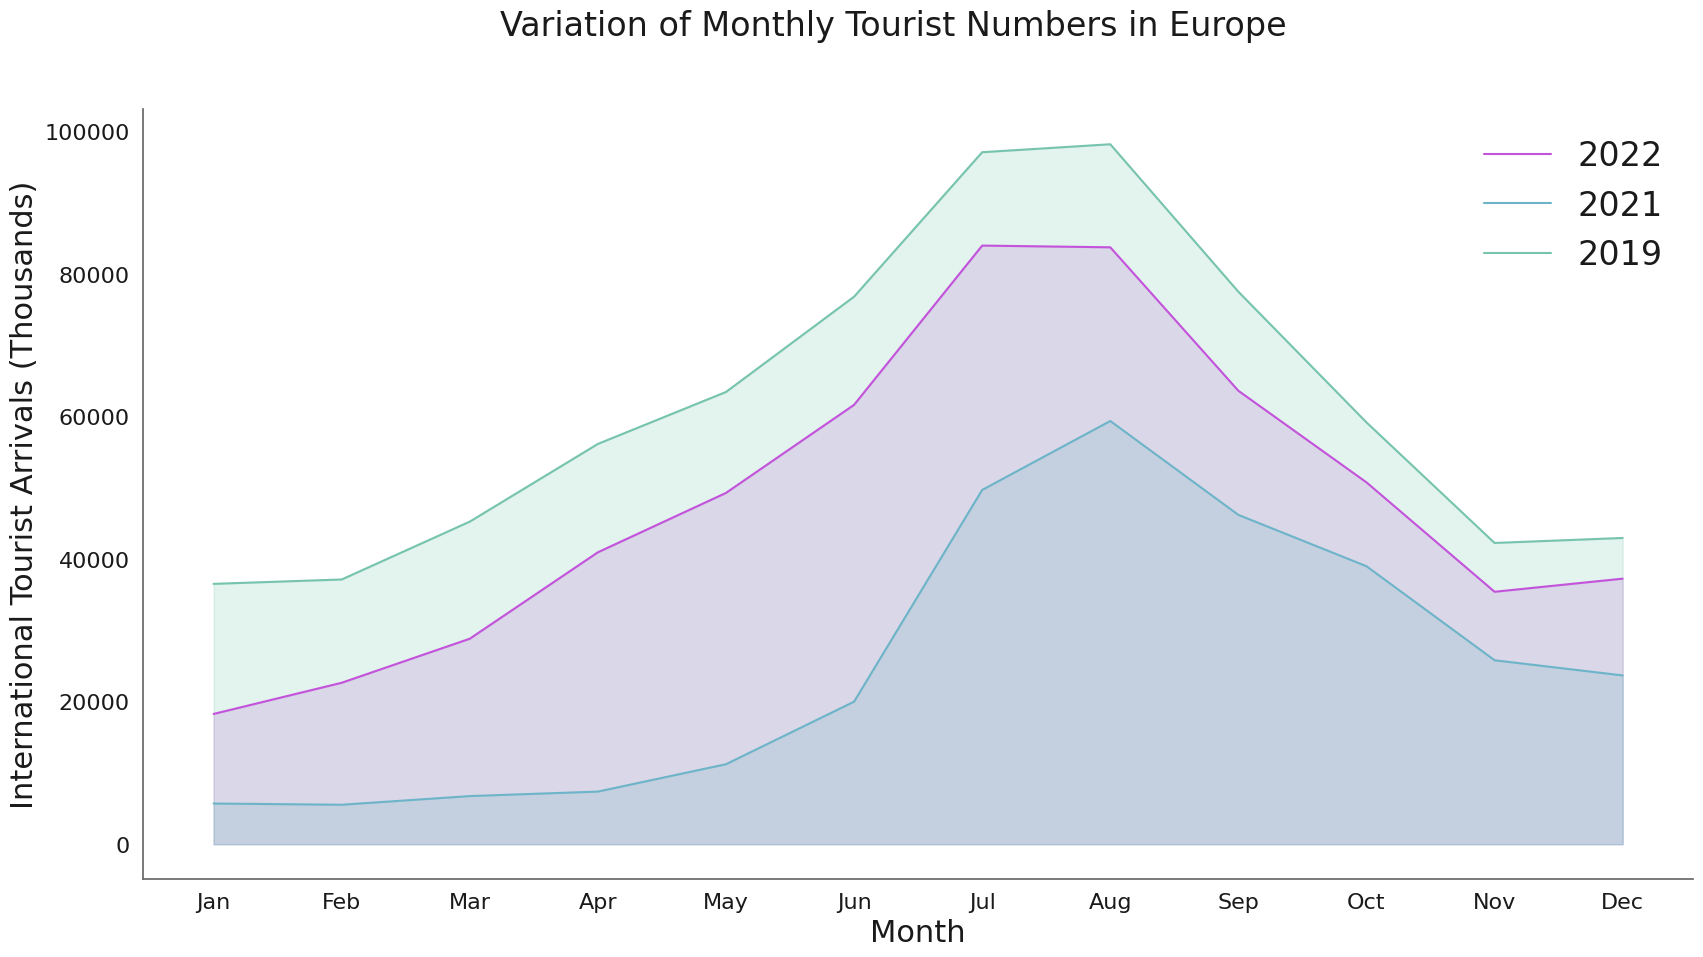

In [ ]:
#example plot
fig, ax = plt.subplots(figsize = (20, 10))
ax.plot(year22['Month'], year22['Europe'], '-', label = '2022')
ax.plot(year21['Month'], year21['Europe'], '-', label = '2021')
ax.plot(year19['Month'], year19['Europe'], '-', label = '2019')

plt.legend(loc='best', fontsize='large', frameon=False)
ax.tick_params(axis="both", labelsize=16)

ax.fill_between(year22['Month'], 0, year22['Europe'], color=G8_Pink, alpha=.2)
ax.fill_between(year21['Month'], 0, year21['Europe'], color=G8_LightBlue, alpha=.2)
ax.fill_between(year19['Month'], 0, year19['Europe'], color=G8_Green, alpha=.2)
ax.set_ylabel('International Tourist Arrivals (Thousands)')
ax.set_xlabel('Month')
fig.suptitle('Variation of Monthly Tourist Numbers in Europe')

In [ ]:
year22.Belgium[35] = np.mean(year22.Belgium)
year22.Denmark[35] = np.mean(year22.Denmark)

<ipython-input-91-063d063389fc>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-91-063d063389fc>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Normalised Data

In [ ]:
#seperate
month = year22[['Month']]
belgium = year22[['Belgium']]
denmark = year22[['Denmark']]
germany = year22[['Germany']]
greece = year22[['Greece']]
netherlands = year22[['Netherlands']]
portugal = year22[['Portugal']]


#normalise sale numbers 
scaler = MinMaxScaler()
normalisedbelgium = scaler.fit_transform(belgium)
normaliseddenmark = scaler.fit_transform(denmark)
normalisedgermany = scaler.fit_transform(germany)
normalisedgreece = scaler.fit_transform(greece)
normalisednetherlands = scaler.fit_transform(netherlands)
normalisedportugal = scaler.fit_transform(portugal)

#back to dataframe
df_month = pd.DataFrame(month)
df_norm_belgium = pd.DataFrame(normalisedbelgium)
df_norm_denmark = pd.DataFrame(normaliseddenmark)
df_norm_germany = pd.DataFrame(normalisedgermany)
df_norm_greece = pd.DataFrame(normalisedgreece)
df_norm_netherlands = pd.DataFrame(normalisednetherlands)
df_norm_portugal = pd.DataFrame(normalisedportugal)

df_month.columns = ['Month']
df_month = df_month.reset_index()
df_norm_belgium.columns = ['Belgium']
df_norm_denmark.columns = ['Denmark']
df_norm_germany.columns = ['Germany']
df_norm_greece.columns = ['Greece']
df_norm_netherlands.columns = ['Netherlands']
df_norm_portugal.columns = ['Portugal']
df_norm_year22 = pd.concat([df_month, df_norm_belgium, df_norm_denmark, df_norm_germany, df_norm_greece, df_norm_netherlands, df_norm_portugal], axis = 1)

Text(0.5, 0.98, 'Normalised Variation in Monthly International Arrivals')

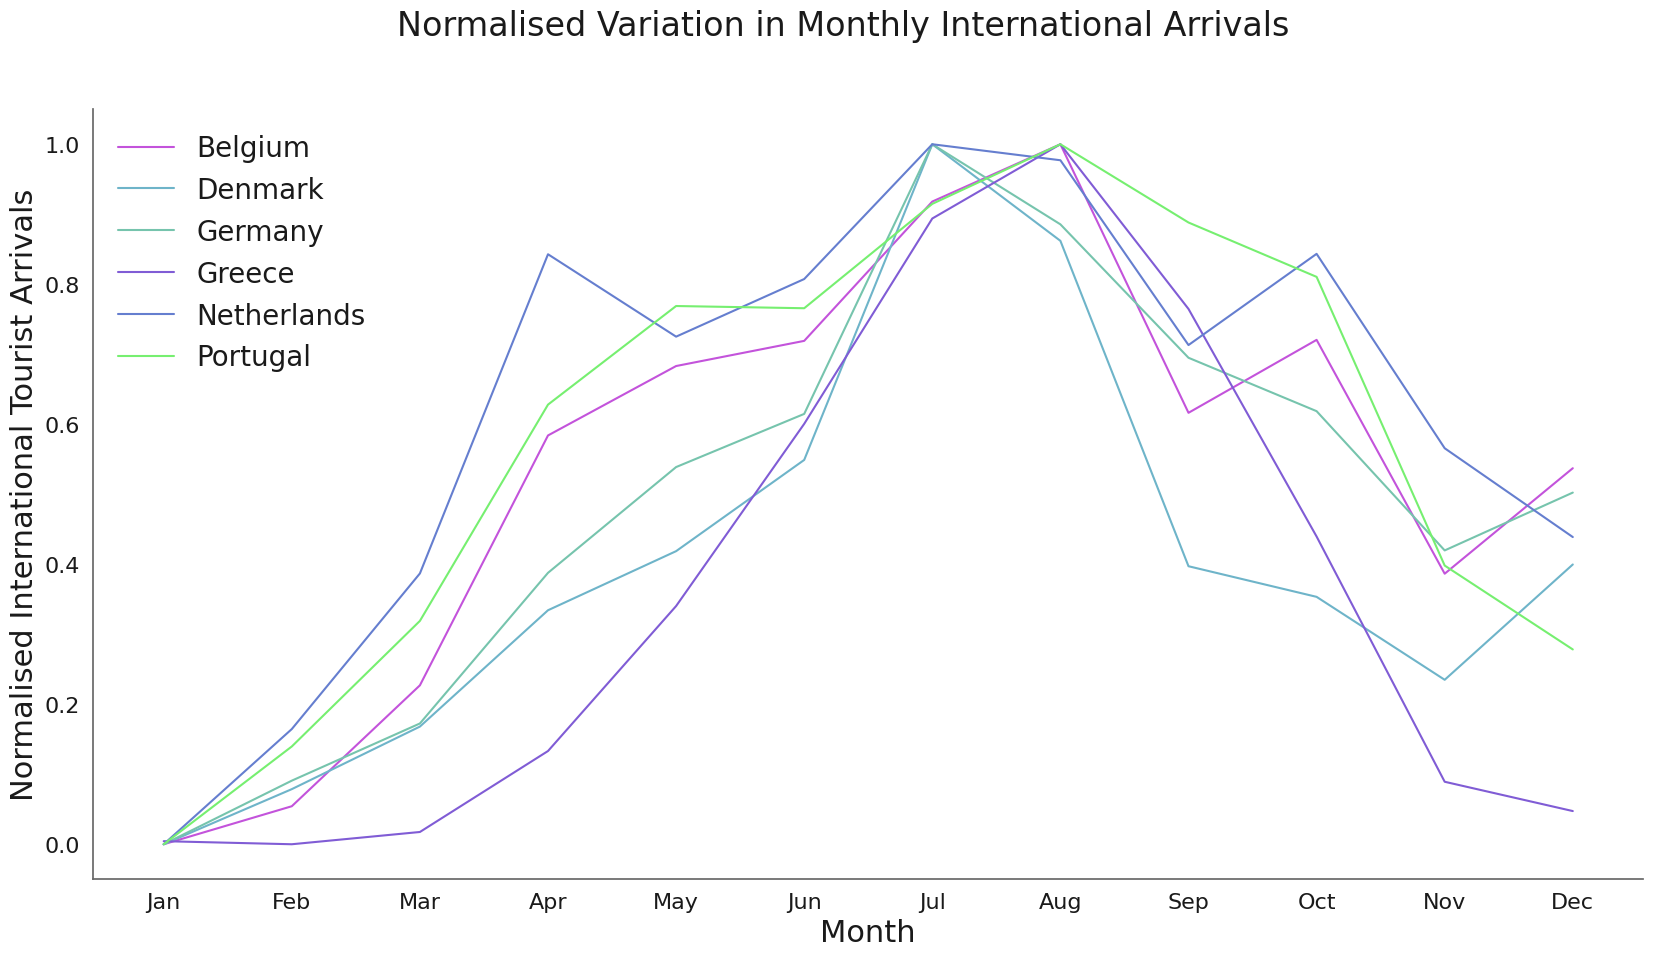

In [ ]:
#normalised data plot
fig, ax = plt.subplots(figsize = (20, 10))
ax.plot(df_norm_year22['Month'], df_norm_year22['Belgium'], '-', label = 'Belgium')
ax.plot(df_norm_year22['Month'], df_norm_year22['Denmark'], '-', label = 'Denmark')
ax.plot(df_norm_year22['Month'], df_norm_year22['Germany'], '-', label = 'Germany')
ax.plot(df_norm_year22['Month'], df_norm_year22['Greece'], '-', label = 'Greece')
ax.plot(df_norm_year22['Month'], df_norm_year22['Netherlands'], '-', label = 'Netherlands')
ax.plot(df_norm_year22['Month'], df_norm_year22['Portugal'], '-', label = 'Portugal')

plt.legend(loc='best', fontsize='medium', frameon=False)
ax.tick_params(axis="both", labelsize=16)
ax.set_ylabel('Normalised International Tourist Arrivals')
ax.set_xlabel('Month')
fig.suptitle('Normalised Variation in Monthly International Arrivals')

### EDA

In [ ]:
# Ensure the price is normaly distributed:
# df["price"] = stats.boxcox(df['price'])[0]
# fig = sm.qqplot(df["price"], line='s')
# stats.shapiro(df["normal_price"])
# px.histogram(df, x = 'price', nbins = 250)

# Box plot median listing price by 
cities_by_lowest_mean_price = listing_df[["city", "price"]].groupby("city").mean().sort_values(by='price').index
cities_by_lowest_mean_price = list(cities_by_lowest_mean_price)
px.box(listing_df, x="city", y = 'price',
       log_y=True,
       category_orders={"city":cities_by_lowest_mean_price},
       title=f"Price distribution for {cities[0].capitalize()}"
)

In [ ]:
import random

random_listing_calendar = cal_df[(cal_df.listing_id == 43073833) & (cal_df.city == "amsterdam")]
random_listing_calendar.head(3)
fig = px.line(x=random_listing_calendar.date, y=random_listing_calendar.price.rolling(14).mean())

ids = [14258648, 2255109, 35854442, 807076205094275342, 43575856]
for i in ids:
  random_listing_calendar = cal_df[(cal_df.listing_id == i) & (cal_df.city == "amsterdam")]
  # random_listing_calendar.head(3)
  fig.add_scatter(x=random_listing_calendar.date, y=random_listing_calendar.price.rolling(14).mean())

for trace in fig['data']:
  trace['showlegend'] = False

fig.update_layout(
    title=f"Rolling 14 Day Average Price of 6 Randomly Selected Listings in {cities[0].capitalize()}"
)
fig.update_xaxes(title_text='Date')
fig.update_yaxes(title_text='Rolling Average Price')
fig.show()


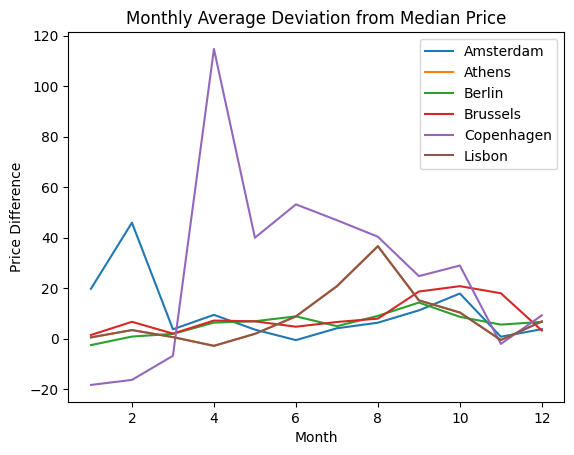

In [ ]:
for city in cities:

  median_df = cal_df[cal_df.city == city].groupby(['listing_id'])['price'].median().reset_index()

  tmp = cal_df[cal_df.city == city].merge(median_df, on=['listing_id'], suffixes=('', '_median'))

  tmp["month"] = tmp.date.dt.month
  tmp['price_difference'] = tmp['price'] - tmp['price_median']

  monthly_avg_difference = tmp.groupby('month')['price_difference'].mean().reset_index()

  plt.plot(monthly_avg_difference["month"], monthly_avg_difference["price_difference"], label=f"{city.capitalize()}")

plt.xlabel('Month')
plt.ylabel('Price Difference')
plt.title('Monthly Average Deviation from Median Price')
plt.legend()
plt.show()


### Regression

In [ ]:
# Combine listing data with calendar pricing data
df = pd.merge(listing_df, cal_df, how="inner", left_on=["id", "city"], right_on=["listing_id", "city"])
df = df.drop(columns = ["listing_id"])


In [ ]:
# remove redundant columns
df = df.drop(columns=[
  "price_x",
  "minimum_nights_x",
  "maximum_nights_x",
  "adjusted_price"
])

In [ ]:
# defragment the frame
df = df.copy()

#### Feature Engineering

In [ ]:
df["num_baths"] = df['bathrooms_text'].str.extract(r'(\d+\.?\d?)').fillna(1).astype(float)
df["num_bed_bath"] = df.num_baths + df.bedrooms
df["beds_per_bedroom"] = df.beds / df.bedrooms

df.availability_30 = df.availability_30 / 30
df.availability_60 = df.availability_60 / 60
df.availability_90 = df.availability_90 / 90
df.availability_365 = df.availability_365 / 365

df["day_of_week"] = df.date.dt.dayofweek
df["month"] = df.date.dt.month

df["tourism_level_by_month"] = df.month.apply(lambda x: df_norm_year22[cities_to_countries[cities[0]]][x-1])

#### Model Fitting

In [ ]:
catagorical_features = [
  # "city", 
  "neighbourhood_cleansed",
  "property_type",
  "room_type",
  # "amenities", ## dealt with: new columns
  "day_of_week",
  "month",
]

response = "price_y"
y = df[[response]]

X = df.drop(response, axis=1)

X = X.drop(columns = [
  "host_since", # time based and probably irrelevant
  "first_review", # time based and probably irrelevant
  "last_review", # time based and probably irrelevant
  "date", # dealt with: added month and day of week
  "amenities", # dealt with: split into new columns
  "bathrooms_text", # dealt with: extracted number into numerical column
  "host_response_time",
  "city",
  "id"
])

In [ ]:
X.info(max_cols=300)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1063247 entries, 0 to 1063246
Data columns (total 155 columns):
 #    Column                            Non-Null Count    Dtype  
---   ------                            --------------    -----  
 0    host_response_rate                1063247 non-null  float64
 1    host_acceptance_rate              1063247 non-null  float64
 2    host_is_superhost                 1063247 non-null  bool   
 3    host_listings_count               1063247 non-null  int64  
 4    host_total_listings_count         1063247 non-null  int64  
 5    neighbourhood_cleansed            1063247 non-null  object 
 6    property_type                     1063247 non-null  object 
 7    room_type                         1063247 non-null  object 
 8    accommodates                      1063247 non-null  int64  
 9    bedrooms                          1063247 non-null  float64
 10   beds                              1063247 non-null  float64
 11   minimum_minimum_nights

In [ ]:
from sklearn.datasets import make_regression
from sklearn.preprocessing import OrdinalEncoder
from sklearn.ensemble import HistGradientBoostingRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.pipeline import make_pipeline

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [ ]:

ordinal_encoder = make_column_transformer(
    (
        OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=np.nan),
        make_column_selector(dtype_include="object"),
    ),
    remainder="passthrough",
    # Use short feature names to make it easier to specify the categorical
    # variables in the HistGradientBoostingRegressor in the next step
    # of the pipeline.
    verbose_feature_names_out=False,
)

model = make_pipeline(
    ordinal_encoder,
    HistGradientBoostingRegressor(
        random_state=42,
        categorical_features=catagorical_features,
    ),
    # GradientBoostingRegressor(
    #     random_state=42,
    # )
).set_output(transform="pandas")

In [ ]:
model.fit(X_train, np.ravel(y_train))

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ordinalencoder',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=nan),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f30139c0370>)],
                                   verbose_feature_names_out=False)),
                ('histgradientboostingregressor',
                 HistGradientBoostingRegressor(categorical_features=['neighbourhood_cleansed',
                                                                     'property_type',
                                                                     'room_type',
                                                                     'day_of_week',
                                                                     'month'],
                                               random_state=42))])

In [ ]:
# R^2 performance:
model.score(X_test, np.ravel(y_test))

0.8656581132632737

In [ ]:
model_rmse = np.sqrt(np.mean((model.predict(X_test)-np.ravel(y_test))**2))
print(f"Model performance RMSE: {model_rmse:.2f}$")


Model performance RMSE: 97.52$


In [ ]:
print(len(model[1].feature_names_in_))
model[1].feature_names_in_

155


array(['neighbourhood_cleansed', 'property_type', 'room_type',
       'host_response_rate', 'host_acceptance_rate', 'host_is_superhost',
       'host_listings_count', 'host_total_listings_count', 'accommodates',
       'bedrooms', 'beds', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm',
       'maximum_nights_avg_ntm', 'availability_30', 'availability_60',
       'availability_90', 'availability_365', 'number_of_reviews',
       'number_of_reviews_ltm', 'number_of_reviews_l30d',
       'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'reviews_per_month', 'has_no_reviews',
       'Smoke alarm', 'Essentials', 'Wifi', 'Kitchen', 'Hot water',
       'Dishes and silverware', 'Hair dryer', 'Hangers',
       'Long term stays allowed', 'Refrigerat

In [ ]:
catagorical_features = [
  "neighbourhood_cleansed",
  "property_type",
  "room_type",
  "day_of_week",
]

X = df.drop(response, axis=1)
X = X.drop(columns = [
  "host_since", # time based and probably irrelevant
  "first_review", # time based and probably irrelevant
  "last_review", # time based and probably irrelevant
  "date", # dealt with: added month and day of week
  "amenities", # dealt with: split into new columns
  "bathrooms_text", # dealt with: extracted number into numerical column
  "host_response_time",
  "city",
  "id",
  "tourism_level_by_month",
  "month"
])



In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [ ]:
ordinal_encoder = make_column_transformer(
    (
        OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=np.nan),
        make_column_selector(dtype_include="object"),
    ),
    remainder="passthrough",
    # Use short feature names to make it easier to specify the categorical
    # variables in the HistGradientBoostingRegressor in the next step
    # of the pipeline.
    verbose_feature_names_out=False,
)

model = make_pipeline(
    ordinal_encoder,
    HistGradientBoostingRegressor(
        random_state=42,
        categorical_features=catagorical_features,
    ),
).set_output(transform="pandas")


In [ ]:
X.info(max_cols=300)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1063247 entries, 0 to 1063246
Data columns (total 153 columns):
 #    Column                            Non-Null Count    Dtype  
---   ------                            --------------    -----  
 0    host_response_rate                1063247 non-null  float64
 1    host_acceptance_rate              1063247 non-null  float64
 2    host_is_superhost                 1063247 non-null  bool   
 3    host_listings_count               1063247 non-null  int64  
 4    host_total_listings_count         1063247 non-null  int64  
 5    neighbourhood_cleansed            1063247 non-null  object 
 6    property_type                     1063247 non-null  object 
 7    room_type                         1063247 non-null  object 
 8    accommodates                      1063247 non-null  int64  
 9    bedrooms                          1063247 non-null  float64
 10   beds                              1063247 non-null  float64
 11   minimum_minimum_nights

In [ ]:
model.fit(X_train, np.ravel(y_train))

In [ ]:
model.score(X_test, np.ravel(y_test))

0.8651136543070586

In [ ]:
model_rmse = np.sqrt(np.mean((model.predict(X_test)-np.ravel(y_test))**2))
print(f"Non tourism features model performance RMSE: {model_rmse:.2f}$")

## Tourism level and price correlation analysis RQ1:

In [ ]:
# load in all cities data into one dataframe
cities = ["amsterdam", "athens", "berlin", "brussels", "copenhagen", "lisbon"]

cal_dfs = {city : pd.read_csv(f"/content/{city}_calendar.csv") for city in cities}
cal_df = pd.concat(cal_dfs, names=['city'])
cal_df = cal_df.reset_index(level=0)

cal_df["date"] = pd.to_datetime(cal_df["date"], format="%Y-%m-%d")
cal_df["month"] = df.date.dt.month

cal_df['price'] = cal_df['price'].replace("[$,]", "", regex=True)
cal_df['price'] = pd.to_numeric(cal_df['price'])

In [ ]:
cities = ["amsterdam", "athens", "berlin"]

In [ ]:
from scipy.stats import pearsonr

for city in cities:
  tmp = cal_df[cal_df.city == city]
  tmp = tmp.dropna(subset=['price'])
  tmp["tourism_level_by_month"] = tmp.month.apply(lambda x: df_norm_year22[cities_to_countries[city]][x-1])

  r, p_value = pearsonr(tmp['tourism_level_by_month'], tmp['price'])

  # Choose a significance level (α)
  alpha = 0.05

  # Check if the correlation is statistically significant
  if p_value < alpha:
      print(f"The correlation between {city}'s tourism level and listing price is statistically significant (r = {r}, p-value = {p_value})")
  else:
      print(f"The correlation between {city}'s tourism level and listing price is NOT statistically significant (r = {r}, p-value = {p_value})")
  result.append(r)

The correlation between amsterdam's tourism level and listing price is statistically significant (r = -0.010104381999689806, p-value = 1.1934062432143844e-58)
The correlation between athens's tourism level and listing price is statistically significant (r = 0.01957252861112069, p-value = 0.0)
The correlation between berlin's tourism level and listing price is statistically significant (r = 0.004857886619497145, p-value = 2.735683894240437e-31)


In [ ]:
print(f"({min(result):.3E} , {max(result):.3E})")

(-6.158E-03 , 4.458E-04)


In [ ]:
df[["tourism_level_by_month", "price_y"]].corr()

,tourism_level_by_month,price_y
tourism_level_by_month,1.000000,-0.017097
price_y,-0.017097,1.000000


TODO: organize below:

In [ ]:
df["tourism_level_by_month"]

KeyError: ignored

In [ ]:
y

0     0.000000
1     0.665154
2     1.000000
3     0.475769
4     0.640748
5     0.672761
6     0.538432
7     0.648127
8     0.785853
9     0.584691
10    0.464057
11    0.282549
12    0.805919
Name: price, dtype: float64

ValueError: ignored

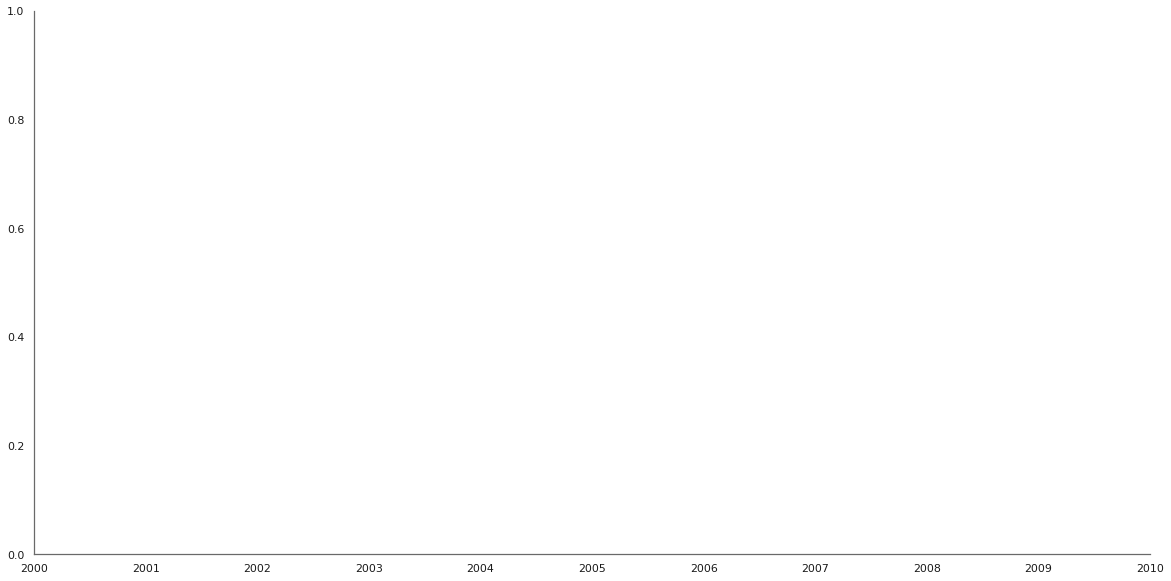

In [ ]:
fig, ax = plt.subplots(figsize = (20, 10))
ax.plot(x, y, '-', label = 'Average Listing Price')
ax.plot(x, df_norm_year22['Portugal'], '-', label = 'Average Tourist Number')
plt.legend(loc='best', fontsize='medium', frameon=False)
ax.tick_params(axis="both", labelsize=16)
ax.set_ylabel('Normalised International Tourist Arrivals')
ax.set_xlabel('Month')
fig.suptitle('Normalised Variation in Monthly International Arrivals')

# Sensitivity